<a href="https://colab.research.google.com/github/KimYongHwi/dacon/blob/main/korea_east_west_power/korea_east_west_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [배경]

태양광 발전은 매일 기상 상황과 계절에 따른 일사량의 영향을 받습니다.

이에 대한 예측이 가능하다면 보다 원활한 전력 수급 계획이 가능합니다.

인공지능 기반 태양광 발전량 예측 모델을 만들어주세요.

## [평가]

- 심사 기준: NMAE-10(Normalized Mean Absolute Error)

- Public 평가: 학습용 제공 데이터를 이용하여 미래 한 달간 발전량 예측 후 평가

- Private 평가: 대회 종료 시점부터 30일간 실제 발전량을 하루씩 평가

- 1일 1회 채점 후 누적 결과 리더보드 반영

- Private 평가 기간 제출물 업데이트 가능 (※제출 후 선택 파일 확인을 반드시 해주시기 바랍니다.)

## [외부 데이터 및 사전학습 모델]

- 예측일 전날 자정까지 확인이 가능한 데이터만 학습 및 추론 과정에서 사용 가능

```
ex) 2021년 6월 11일 예측 -> 2021년 6월 10일 24:00까지 획득 가능한 데이터만 사용
(6월 10일 기상 관측 정보, 6월10일에 예보한 6월 11일 예보 등...)
```

- 예측 이전 시점의 데이터만 사용 가능

- 공공데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용

- 사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함

- 대회 진행 중 data leakage 및 규칙 위반 사항이 의심되는 경우 코드 제출 요청을 할 수 있으며 요청 2일 이내 코드 미제출 혹은 외부 데이터 사용이 확인되었을 경우 리더보드 기록 삭제

- 최종 평가시 외부데이터 및 출처 제출

## [유의 사항]

- 1일 최대 제출 횟수: 3회
- 사용 가능 언어: Python, R
- 모델 학습에서 검증 혹은 평가 데이터셋 활용 시(Data Leakage 등) 실격
- 최종 순위는 선택된 파일 중에서 채점되므로 참가자는 제출 창에서 자신이 최종적으로 채점 받고 싶은 파일을 선택해야 함
- 대회 직후 공개되는 Private 랭킹은 최종 순위가 아니며 코드 검증 후 수상자가 결정됨
- 데이콘은 부정 제출 행위를 금지하고 있으며 데이콘 대회 부정 제출 이력이 있는 경우 평가가 제한됩니다. 자세한 사항은 아래의 링크를 참고해 주시기 바랍니다. https://dacon.io/notice/notice/13

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
from pathlib import Path
from functools import reduce

In [71]:
folder = "dacon"
project_dir = "korea_east_west_power"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)

for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])

print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/dacon/korea_east_west_power


In [72]:
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
energy = pd.read_csv('./data/energy.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')

## energy.csv - 발전소별 발전량
- time : 1시간 단위 계량된 시간 (ex-2018-03-01 1:00:00 => 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
- dangjin_floating : 당진수상태양광 발전량(KW)
- dangjin_warehouse : 당진자재창고태양광 발전량(KW)
- dangjin : 당진태양광 발전량(KW)
- ulsan : 울산태양광 발전량(KW)

In [73]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0
25628,2021-01-31 21:00:00,0.0,0.0,0,0
25629,2021-01-31 22:00:00,0.0,0.0,0,0
25630,2021-01-31 23:00:00,0.0,0.0,0,0


In [74]:
def to_datetime(date_str):
    if date_str[11:13] != '24':
        return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')

    date_str = date_str[0:11] + '00' + date_str[13:]
    
    return pd.to_datetime(date_str, format='%Y%m%d %H:%M:%S') + \
           dt.timedelta(days=1)

In [75]:
# 24:00:00은 다음날 00:00:00으로 변경
energy['time'] = energy['time'].apply(to_datetime)

## dangjin_fcst_data.csv - 당진지역 발전소 동네 예보
- Forecast time : 예보 발표 시점
- forecast : 예보 시간 (ex - Forecast time:2018-03-01 11:00:00, forecast:4.0 => 2018-03-01 11:00:00에 발표한 2018-03-01 15:00:00 예보

### 예보 발표 시점 'forecast'시간 후 기상 예보
- Temperature : 온도(℃)
- Humidity : 습도(%)
- WindSpeed : 풍속(m/s)
- WindDirection : 풍향(º)
- Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

In [76]:
def get_14_fcst(df):
    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])
    # 14시 예보만을 사용
    df14 = df[df['Forecast_time'].dt.hour == 14]
    # 다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(00:00)부터 33시간 후(23:00) 데이터만 사용
    df14 = df14[(df14['forecast'] >= 10)&(df14['forecast'] <= 33)]
    df14['Forecast_time'] = df14['Forecast_time'] + df14['forecast'].map(lambda x: pd.DateOffset(hours=x))

    return df14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']] 

In [77]:
 dangjin_fcst_14 = get_14_fcst(dangjin_fcst)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [78]:
# 당진 석운면 기상 데이터
dangjin_feb_temperature = pd.read_csv('./data/dangjin/석문면_3시간기온_201802_201802.csv')
dangjin_feb_humidity = pd.read_csv('./data/dangjin/석문면_습도_201802_201802.csv')
dangjin_feb_wind_direction = pd.read_csv('./data/dangjin/석문면_풍향_201802_201802.csv')
dangjin_feb_wind_speed = pd.read_csv('./data/dangjin/석문면_풍속_201802_201802.csv')
dangjin_feb_cloud = pd.read_csv('./data/dangjin/석문면_하늘상태_201802_201802.csv')

In [79]:
# 14시 예보만을 사용
def filter_feb_14hour_data(df, key):
    df = df[(df[' format: day'] == 28) & (df['hour'] == 1400)]
    df_ = df.copy()
    df_[key] = df_.copy()[df_.columns[-1]].astype(float)
    df_['Forecast time'] = pd.to_datetime('2018-02-28 14:00:00')
    df_['forecast'] = df_['forecast'].astype(float)
    df_['Forecast_time'] = df_['Forecast time'] + df_['forecast'].map(lambda x: pd.DateOffset(hours=x))
    df_ = df_[(df_['forecast'] >= 10)&(df_['forecast'] <= 33)]

    return df_[['Forecast_time', 'forecast', key]]

In [80]:
dangjin_feb_temperature = filter_feb_14hour_data(dangjin_feb_temperature, 'Temperature')
dangjin_feb_humidity = filter_feb_14hour_data(dangjin_feb_humidity, 'Humidity')
dangjin_feb_wind_direction = filter_feb_14hour_data(dangjin_feb_wind_direction, 'WindDirection')
dangjin_feb_wind_speed = filter_feb_14hour_data(dangjin_feb_wind_speed, 'WindSpeed')
dangjin_feb_cloud = filter_feb_14hour_data(dangjin_feb_cloud, 'Cloud')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [81]:
dfs = [dangjin_feb_temperature, dangjin_feb_humidity, dangjin_feb_wind_direction, dangjin_feb_wind_speed, dangjin_feb_cloud]
# 2월 14시 데이터 temp, hum, wind_dir, wind_speed, cloud merge
dangjin_feb_fcst = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how = 'left'), dfs)

In [82]:
dangjin_feb_fcst = dangjin_feb_fcst[['Forecast_time', 'Temperature', 'Humidity', 'WindDirection', 'WindSpeed', 'Cloud']]

In [83]:
dangjin_fcst_14 = dangjin_feb_fcst.append(dangjin_fcst_14)

In [84]:
def get_interpolate(fcst_df):
    fcst_14_ = pd.DataFrame()
    fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-01 00:00:00', end='2021-03-01 23:00:00', freq='H')
    # 예보는 3시간 단위로 데이터가 있지만 fcst_14_는 1시간 단위로 dataframe을 만들기 때문에 중간에 NaN값들이 존재
    fcst_14_ = pd.merge(fcst_14_, fcst_df, on='Forecast_time', how='outer')

    # 선형보간법을 활용하여 비어있는 값을 채움
    return fcst_14_.interpolate()

In [85]:
dangjin_fcst_inter = get_interpolate(dangjin_fcst_14)

In [86]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)

    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['year'] = concat_df['Forecast_time'].dt.year
    concat_df['month'] = concat_df['Forecast_time'].dt.month
    concat_df['day'] = concat_df['Forecast_time'].dt.day
    concat_df['hour'] = concat_df['Forecast_time'].dt.hour
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]

    # 발전량이 0인 데이터를 제외
    feature_df = feature_df[(feature_df[target]!=0) & (feature_df[target].notnull())]

    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]

    train_x = train_df.loc[:, 'month':'Cloud']
    train_y = train_df[target]
    
    val_x = val_df.loc[:, 'month':'Cloud']
    val_y = val_df[target]
    
    return train_x, train_y, val_x, val_y

In [87]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst_inter, target='dangjin_floating')

In [88]:
from sklearn.preprocessing import StandardScaler

def day_scaler(train, val_x):
    scaler = StandardScaler()
    
    values = train['day'].values
    values = values.reshape((len(values), 1))

    train['day'] = scaler.fit_transform(values).reshape(-1,)

    values = val_x['day'].values
    values = values.reshape((len(values), 1))
    
    val_x['day'] = scaler.transform(values).reshape(-1, )

    return train, val_x

In [89]:
train_x, val_x = day_scaler(train_x, val_x)

In [90]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [91]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [92]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [93]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from lightgbm import LGBMRegressor

In [94]:
random_params = {
    'n_estimators': range(100, 500),
    'learning_rate': np.arange(0.01, 0.1, 0.001),
    'max_depth': range(3, 10),
    'metric':'mae',
}

def get_hyperparams(X, y):
    skfold = StratifiedKFold(n_splits = 4, shuffle = True)
    model = LGBMRegressor()
    random_search = RandomizedSearchCV(model, random_params, scoring = 'neg_mean_absolute_error', n_jobs = -1, cv = skfold)
    random_search.fit(X, y)

    print(random_search.best_params_)

    return random_search.best_params_

In [95]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

### 당진 수상 태양광 예측

In [101]:
hyperparams = get_hyperparams(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 389, 'metric': 'm', 'max_depth': 9, 'learning_rate': 0.06199999999999996}


In [102]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [103]:
dangjin_floating_model = lgb.train(hyperparams, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=500)
# dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=500)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[51]	valid_0's score: 7.96119


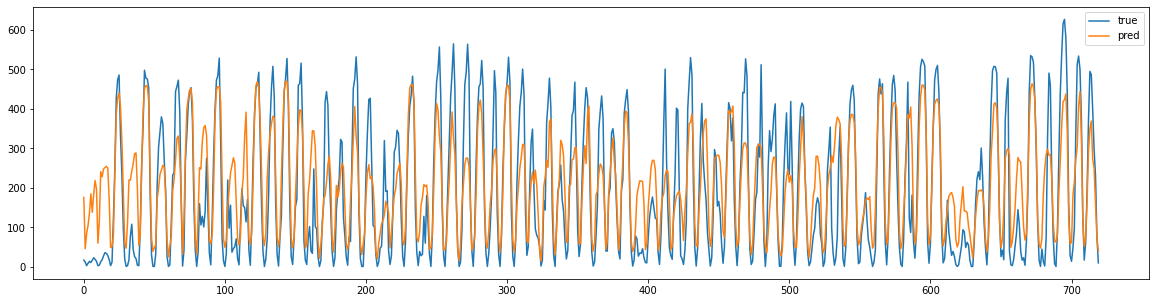

CV Score :  7.96119412485871


In [104]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진 자재창고 태양광 예측

In [105]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst_inter, target='dangjin_warehouse')

In [106]:
train_x, val_x = day_scaler(train_x, val_x)

In [107]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [108]:
hyperparams = get_hyperparams(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 349, 'metric': 'm', 'max_depth': 9, 'learning_rate': 0.07099999999999995}


In [109]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [110]:
dangjin_warehouse_model = lgb.train(hyperparams, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)
# dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's score: 7.16394


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


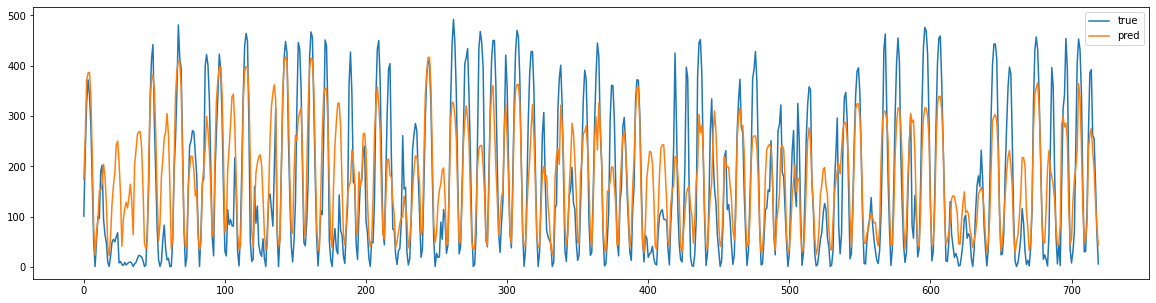

CV Score :  7.163941727064647


In [111]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진 태양광 예측

In [112]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst_inter, target='dangjin')

In [113]:
train_x, val_x = day_scaler(train_x, val_x)

In [114]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [115]:
hyperparams = get_hyperparams(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 289, 'metric': 'e', 'max_depth': 9, 'learning_rate': 0.09599999999999992}


In [116]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [117]:
dangjin_model = lgb.train(hyperparams, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)
# dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[37]	valid_0's score: 10.2206


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


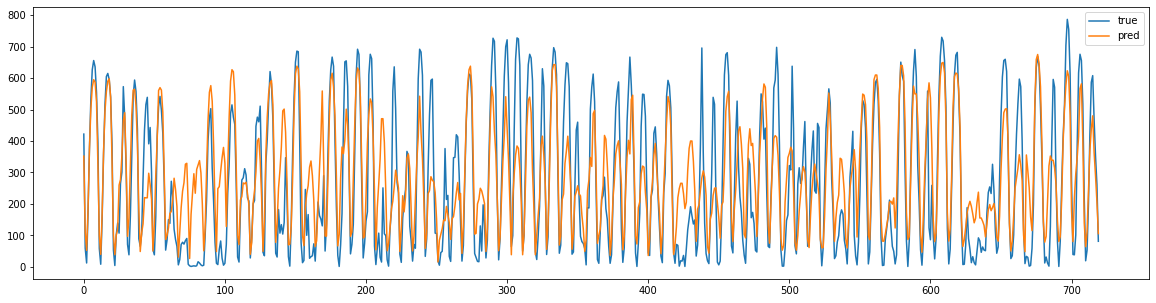

CV Score :  10.220570971289229


In [118]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## ulsan_fcst_data.csv - 울산지역 발전소 동네 예보
- Forecast time : 예보 발표 시점
- forecast : 예보 시간 (ex - Forecast time:2018-03-01 11:00:00, forecast:4.0 => 2018-03-01 11:00:00에 발표한 2018-03-01 15:00:00 예보

### 예보 발표 시점 'forecast'시간 후 기상 예보
- Temperature : 온도(℃)
- Humidity : 습도(%)
- WindSpeed : 풍속(m/s)
- WindDirection : 풍향(º)
- Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

In [119]:
ulsan_fcst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162208 entries, 0 to 162207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Forecast time  162208 non-null  object 
 1   forecast       162208 non-null  float64
 2   Temperature    162208 non-null  float64
 3   Humidity       162208 non-null  float64
 4   WindSpeed      162208 non-null  float64
 5   WindDirection  162208 non-null  float64
 6   Cloud          162208 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.7+ MB


In [120]:
ulsan_fcst_14 = get_14_fcst(ulsan_fcst)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [121]:
# 울산 석운면 기상 데이터
ulsan_feb_temperature = pd.read_csv('./data/ulsan/선암동_3시간기온_201802_201802.csv')
ulsan_feb_humidity = pd.read_csv('./data/ulsan/선암동_습도_201802_201802.csv')
ulsan_feb_wind_direction = pd.read_csv('./data/ulsan/선암동_풍향_201802_201802.csv')
ulsan_feb_wind_speed = pd.read_csv('./data/ulsan/선암동_풍속_201802_201802.csv')
ulsan_feb_cloud = pd.read_csv('./data/ulsan/선암동_하늘상태_201802_201802.csv')

In [122]:
ulsan_feb_temperature = filter_feb_14hour_data(ulsan_feb_temperature, 'Temperature')
ulsan_feb_humidity = filter_feb_14hour_data(ulsan_feb_humidity, 'Humidity')
ulsan_feb_wind_direction = filter_feb_14hour_data(ulsan_feb_wind_direction, 'WindDirection')
ulsan_feb_wind_speed = filter_feb_14hour_data(ulsan_feb_wind_speed, 'WindSpeed')
ulsan_feb_cloud = filter_feb_14hour_data(ulsan_feb_cloud, 'Cloud')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [123]:
dfs = [ulsan_feb_temperature, ulsan_feb_humidity, ulsan_feb_wind_direction, ulsan_feb_wind_speed, ulsan_feb_cloud]
# 2월 14시 데이터 temp, hum, wind_dir, wind_speed, cloud merge
ulsan_feb_fcst = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how = 'left'), dfs)

In [124]:
ulsan_feb_fcst = ulsan_feb_fcst[['Forecast_time', 'Temperature', 'Humidity', 'WindDirection', 'WindSpeed', 'Cloud']]

In [125]:
ulsan_fcst_14 = ulsan_feb_fcst.append(ulsan_fcst_14)

In [126]:
ulsan_fcst_inter = get_interpolate(ulsan_fcst_14)

### 울산 태양광 예측

In [129]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst_inter, target='ulsan')

In [130]:
train_x, val_x = day_scaler(train_x, val_x)

In [131]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [132]:
hyperparams = get_hyperparams(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 464, 'metric': 'e', 'max_depth': 9, 'learning_rate': 0.05699999999999996}


In [133]:
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)

In [134]:
ulsan_model = lgb.train(hyperparams, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)
# ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=1000)

Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[137]	valid_0's score: 3.14384


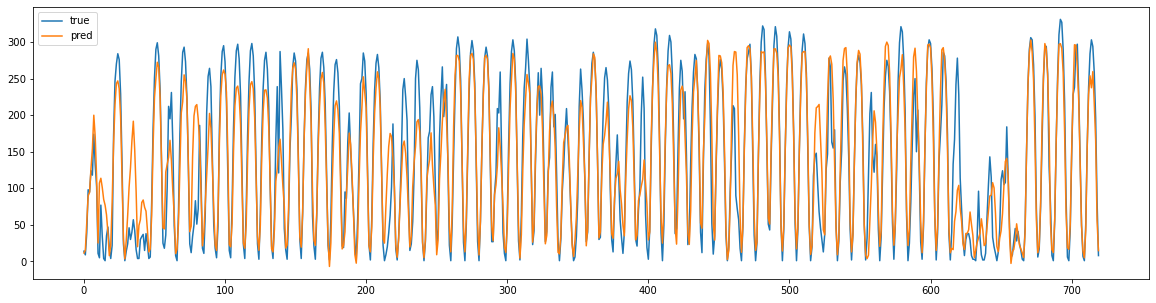

CV Score :  3.143837107967312


In [135]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [136]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()

    test_df['year'] = test_df['Forecast_time'].dt.year
    test_df['month'] = test_df['Forecast_time'].dt.month
    test_df['day'] = test_df['Forecast_time'].dt.day
    test_df['hour'] = test_df['Forecast_time'].dt.hour
    
    test_df = test_df[['month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [137]:
dangjin_test = test_datast(dangjin_fcst_inter)
ulsan_test = test_datast(ulsan_fcst_inter)

In [138]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

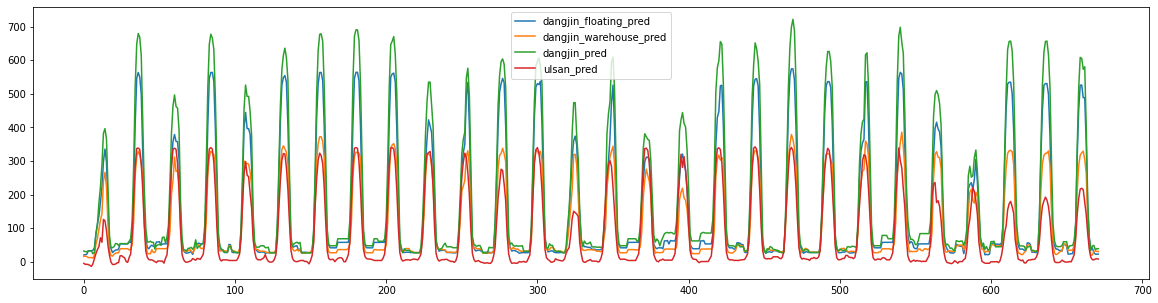

In [139]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [141]:
submission = pd.read_csv('./data/sample_submission.csv')

In [142]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [143]:
submission.to_csv('./data/day_scaler_submission.csv', index=False)